In [5]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeRegressor

# Task 1

Depth with lowest median difference : 21


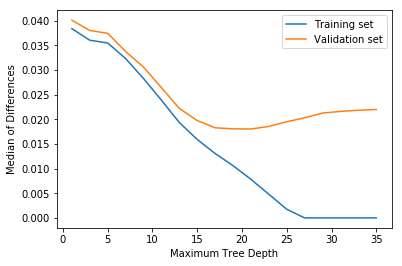

In [6]:
def get_features_targets(data):
    features = np.zeros((data.shape[0], 4))
    features[:, 0] = data['u'] - data['g']
    features[:, 1] = data['g'] - data['r']
    features[:, 2] = data['r'] - data['i']
    features[:, 3] = data['i'] - data['z']
    
    return features, data['redshift']


def median_diff(predicted, actual):
    return np.median(np.abs(predicted - actual))


def accuracy_by_treedepth(features, targets, depths):
    # split the data into testing and training sets
    split_index = int(0.5 * len(features))
    train_features = features[:split_index]
    test_features = features[split_index:]
    
    train_targets = targets[:split_index]
    test_targets = targets[split_index:]

    # initialise arrays or lists to store the accuracies for the below loop
    train_accuracy = []
    test_accuracy = []

    # loop through depths
    for depth in depths:
        # initialize model with the maximum depth. 
        dtr = DecisionTreeRegressor(max_depth=depth)
    
        # train the model using the training set
        dtr.fit(train_features, train_targets)
    
        # get predictions for the training set and calculate their median_diff
        train_predictions = dtr.predict(train_features)
        train_median_diff = median_diff(train_targets, train_predictions)
        train_accuracy.append(train_median_diff)
    
        # get predictions for the testing set and calculate their median_diff
        test_predictions = dtr.predict(test_features)
        test_median_diff = median_diff(test_targets, test_predictions)
        test_accuracy.append(test_median_diff)
        
    # return the accuracies for the training and testing sets
    return train_accuracy, test_accuracy


def main():
    data = np.load('data1/sdss_galaxy_colors.npy')
    features, targets = get_features_targets(data)

    # Generate several depths to test
    tree_depths = [i for i in range(1, 36, 2)]

    # Call the function
    train_med_diffs, test_med_diffs = accuracy_by_treedepth(features, targets, tree_depths)
    print("Depth with lowest median difference : {}".format(tree_depths[test_med_diffs.index(min(test_med_diffs))]))

    # Plot the results
    train_plot = plt.plot(tree_depths, train_med_diffs, label='Training set')
    test_plot = plt.plot(tree_depths, test_med_diffs, label='Validation set')
    plt.xlabel("Maximum Tree Depth")
    plt.ylabel("Median of Differences")
    plt.legend()
    plt.show()


if __name__ == "__main__":
    main()